<a href="https://colab.research.google.com/github/Patriciafg27/MIA3_Actividades_Grupo4/blob/main/Jumanji%20Pedro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

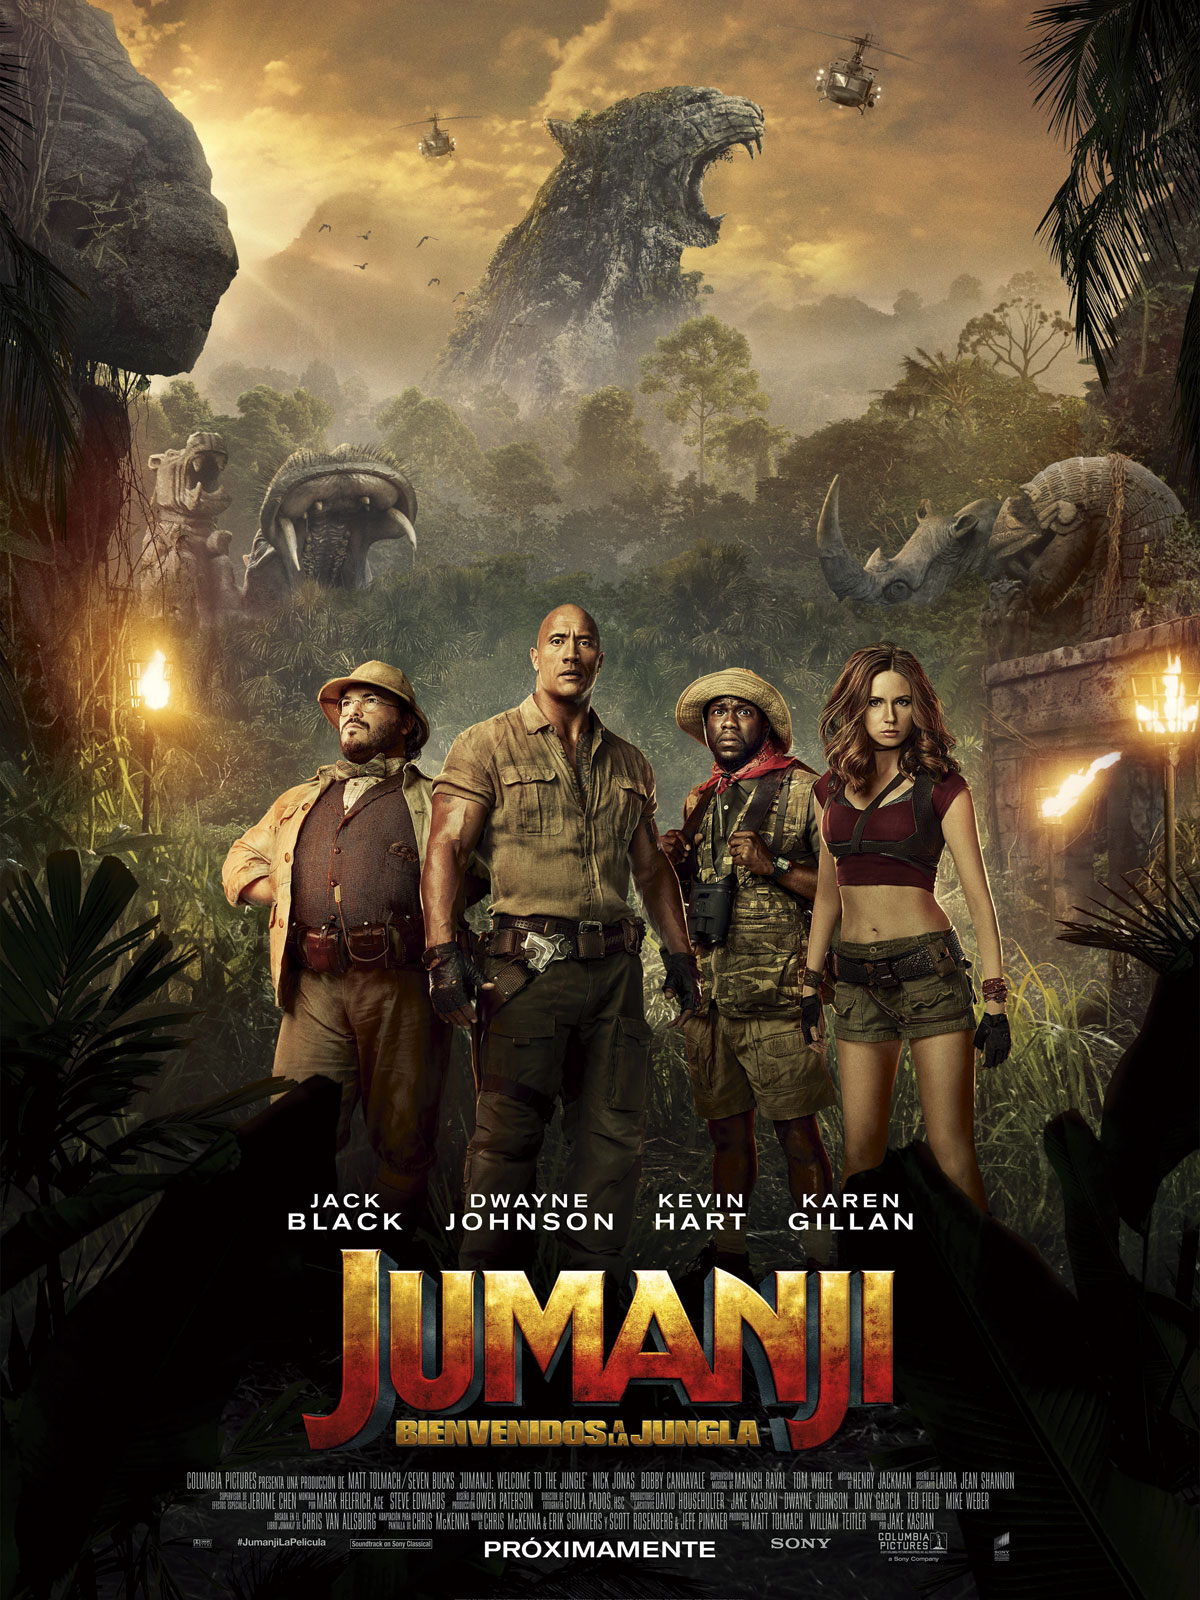

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [26]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [3]:
train_data_dir = 'cats_and_dogs_filtered/train'
validation_data_dir = 'cats_and_dogs_filtered/validation'

batch_size = 32

In [4]:
def preprocess_input(x):
     return x/255.

In [5]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='mirror',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

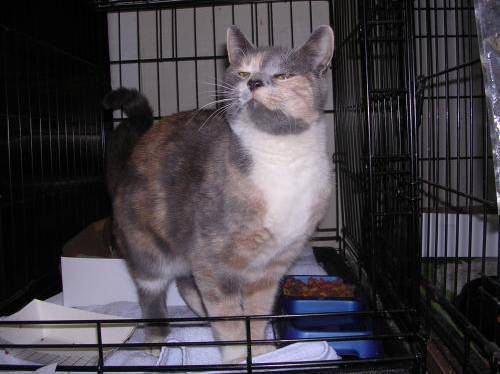

In [6]:
path = "./cats_and_dogs_filtered/train/cats"
imagen = load_img(os.path.join(path,os.listdir(path)[2]))
display(imagen)

In [7]:
np.array(imagen).shape

(374, 500, 3)

In [8]:
imagen_exp = np.expand_dims(np.array(imagen),axis=0)
imagen_exp.shape

(1, 374, 500, 3)

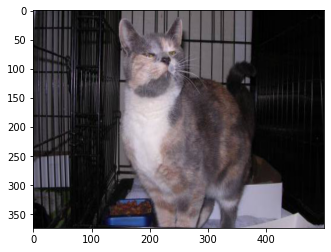

In [9]:
plt.imshow(train_datagen.flow(imagen_exp)[0][0])

In [10]:
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical') # binary, categorical, sparse

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical') # binary, categorical, sparse

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [13]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

In [14]:
from matplotlib.ticker import MaxNLocator
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# **Modelo 3**

In [27]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu',
                 input_shape=normed_dims+(3,),
                 padding = 'same'))
model.add(Conv2D(32, (3,3), activation='relu',padding = 'same'))
model.add(AveragePooling2D((2,2)))
model.add(Conv2D(16, (5,5), activation='relu'))
model.add(Conv2D(8, (5,5), activation='relu'))
model.add(AveragePooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

In [28]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

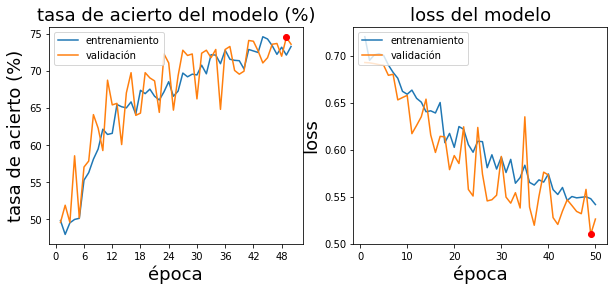

In [29]:
epochs = 50

modelpath="modelo3_elmejor.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [30]:
model = load_model(modelpath)

In [32]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 10.0 MB/s 


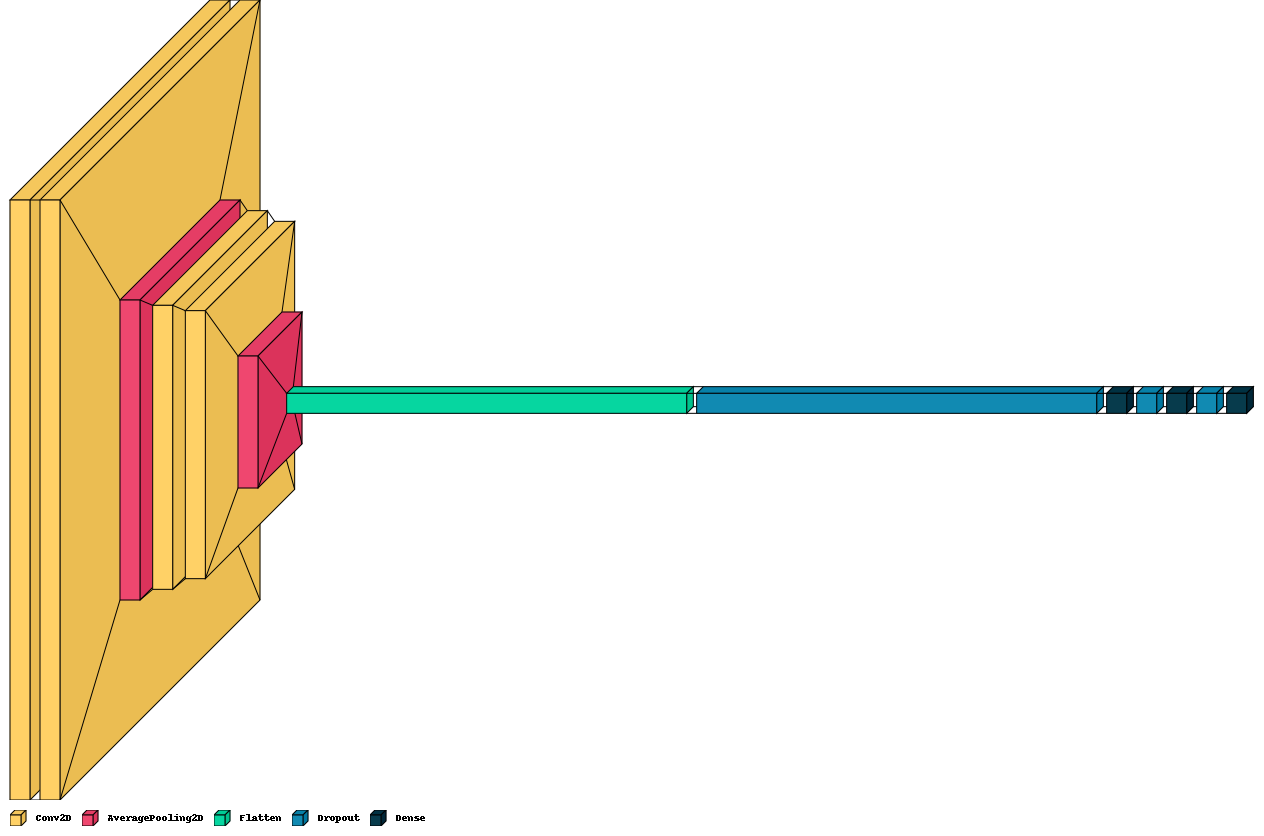

In [33]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model,legend=True, font=ImageFont.load_default())

# *Resultados*

In [34]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

63/63 [==============================] - 14s 221ms/step - loss: 0.5141 - accuracy: 0.7535
Train loss    : 0.5140970349311829
Train accuracy: 0.7534999847412109

32/32 [==============================] - 3s 94ms/step - loss: 0.5116 - accuracy: 0.7440
Val loss    : 0.5116214156150818
Val accuracy: 0.7440000176429749



In [35]:
y_real = validation_generator.classes
y_pred_proba = model.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.81      0.76       500
           1       0.78      0.67      0.72       500

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



# Visualización ejemplos

In [36]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio test
    shuffle=True,
    class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [37]:
X_val,y_val = validation_generator2.next()
class_indices = validation_generator2.class_indices

Probabilidad perro: 5.9%
Probabilidad gato : 94.1%


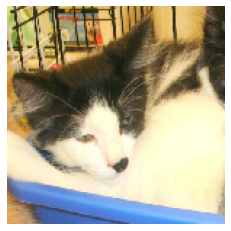

In [63]:
import random

image = X_val[random.randint(0,batch_size)].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

# Features Maps

In [50]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 150, 150, 3)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


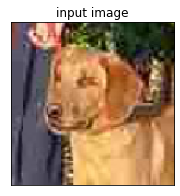

Salidas capa conv2d_4 (1, 150, 150, 64)


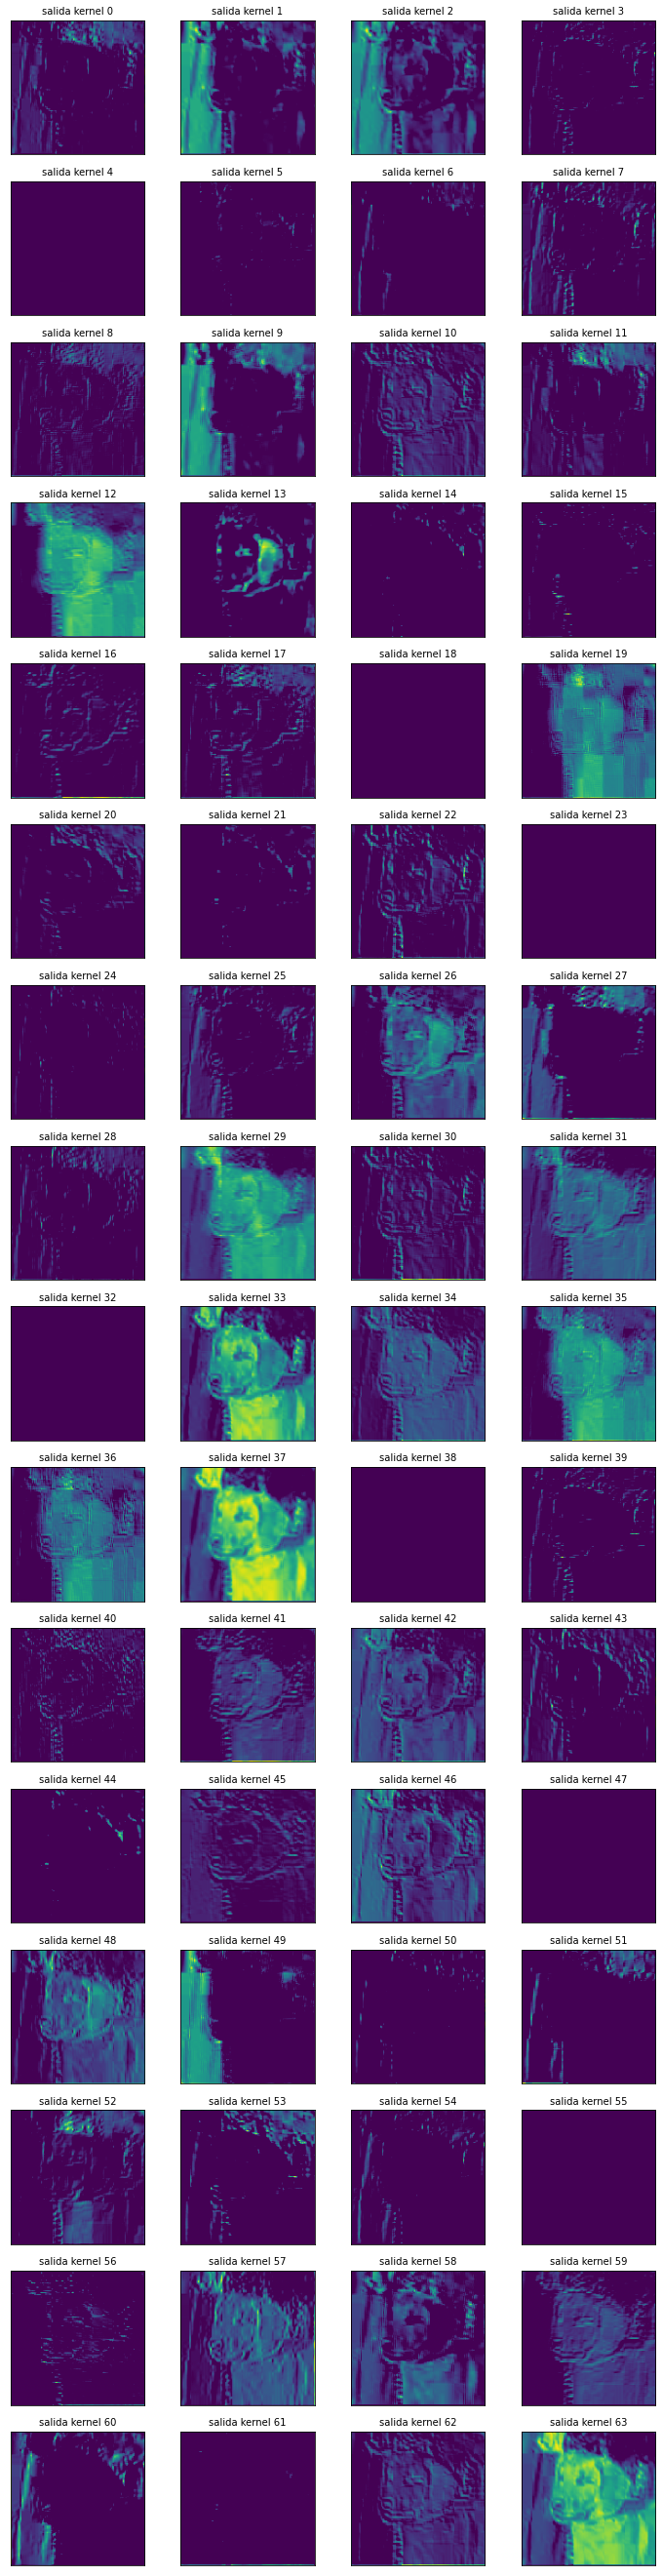

In [51]:
ejemplo = 1

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

In [52]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_val[ejemplo:(ejemplo+1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


ValueError: ignored

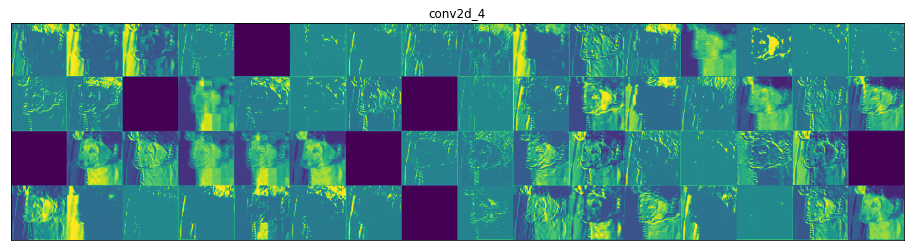

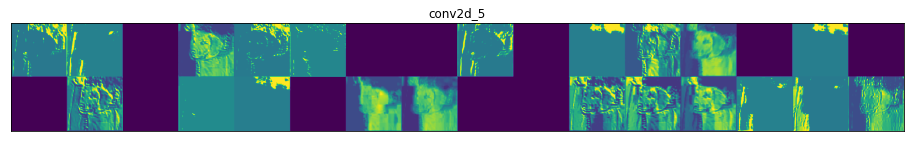

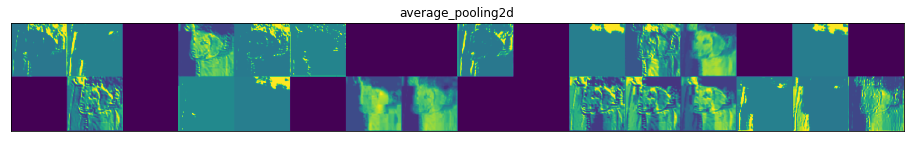

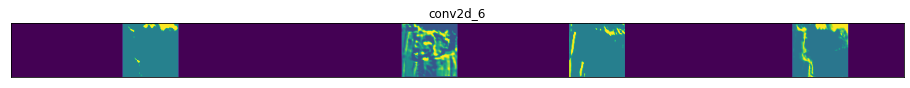

In [53]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Heatmaps

In [54]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["cats"]]
    print("Probabilidad clase gato : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["dogs"]]
    print("Probabilidad clase perro: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

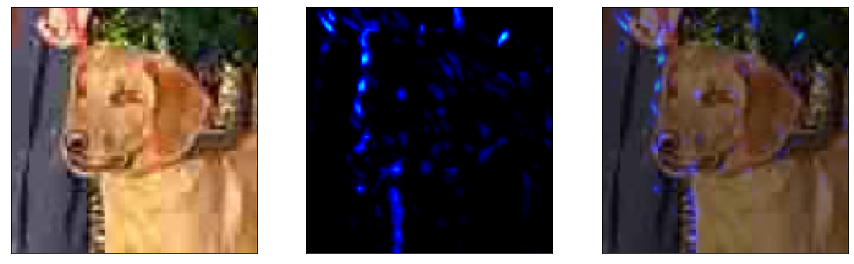

Probabilidad clase gato : 8.7%
Probabilidad clase perro: 91.3%





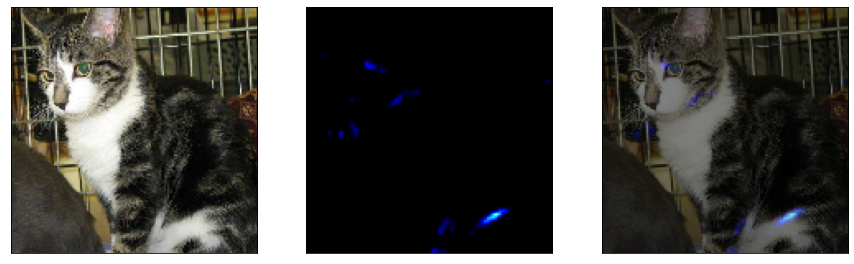

Probabilidad clase gato : 71.0%
Probabilidad clase perro: 29.0%





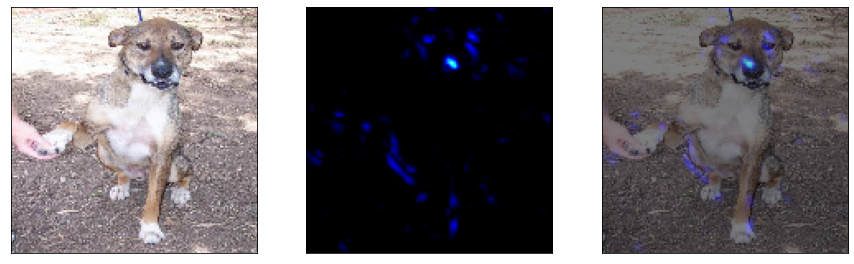

Probabilidad clase gato : 45.8%
Probabilidad clase perro: 54.2%





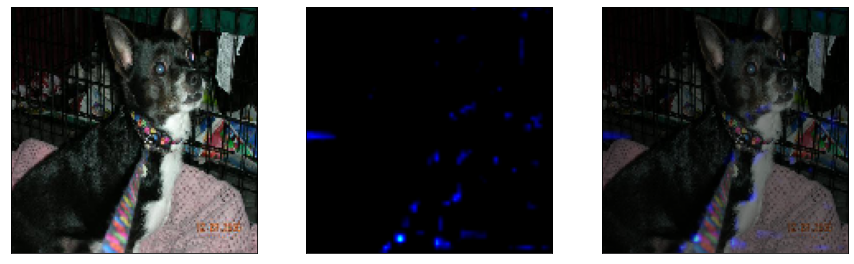

Probabilidad clase gato : 83.2%
Probabilidad clase perro: 16.8%





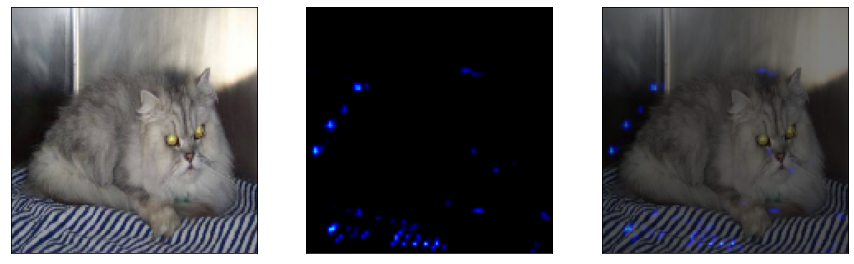

Probabilidad clase gato : 86.8%
Probabilidad clase perro: 13.2%





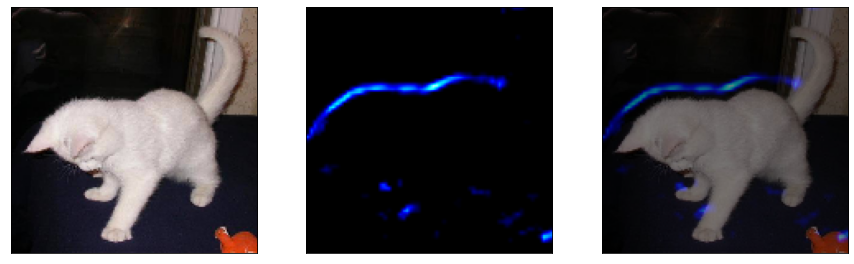

Probabilidad clase gato : 66.7%
Probabilidad clase perro: 33.3%





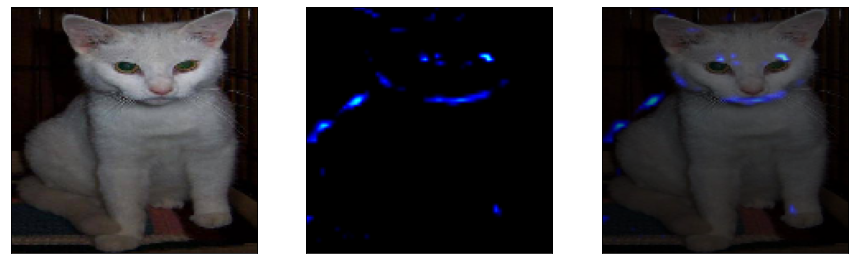

Probabilidad clase gato : 65.1%
Probabilidad clase perro: 34.9%





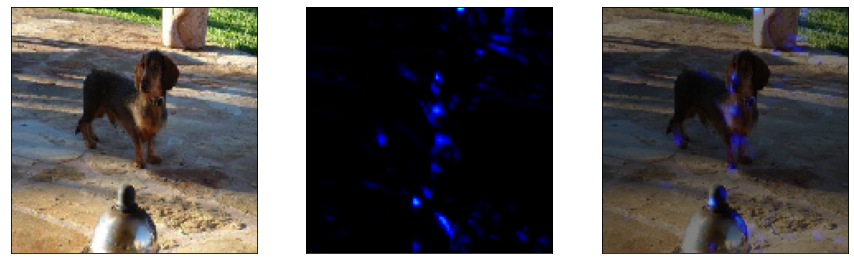

Probabilidad clase gato : 14.9%
Probabilidad clase perro: 85.1%





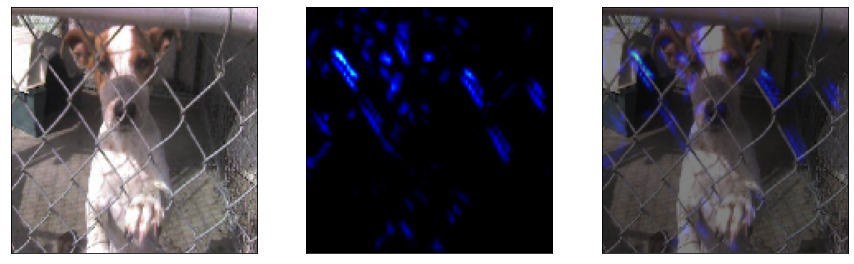

Probabilidad clase gato : 21.4%
Probabilidad clase perro: 78.6%





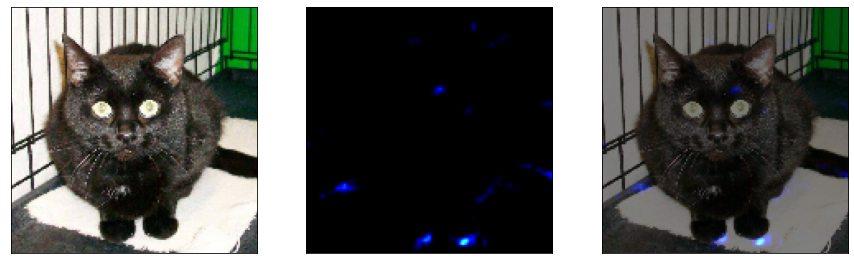

Probabilidad clase gato : 65.8%
Probabilidad clase perro: 34.2%





In [55]:
ind = 1 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)
#ind = 200

for i in range(ind, ind+10):
    show_heatmap(model, X_val[i])